In [139]:
import json, pycm, itertools, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
val_model_agnostic_data = json.load(open('reference/val.model-agnostic.json', 'r'))

In [3]:
classifier_data = json.load(open('results/val.model-agnostic.gpt-4-0125-preview-v13-20-sample-selection-4-2024-01-28', 'r'))

In [39]:
val_model_agnostic_data[0]

{'hyp': 'Resembling or characteristic of a weasel.',
 'ref': 'tgt',
 'src': 'The writer had just entered into his eighteenth year , when he met at the table of a certain Anglo - Germanist an individual , apparently somewhat under thirty , of middle stature , a thin and <define> weaselly </define> figure , a sallow complexion , a certain obliquity of vision , and a large pair of spectacles .',
 'tgt': 'Resembling a weasel (in appearance).',
 'model': '',
 'task': 'DM',
 'labels': ['Hallucination',
  'Not Hallucination',
  'Not Hallucination',
  'Not Hallucination',
  'Not Hallucination'],
 'label': 'Not Hallucination',
 'p(Hallucination)': 0.2}

In [54]:
labeling = [ 
    { 
        "h0": dp["labels"][0], 
        "h1": dp["labels"][1], 
        "h2": dp["labels"][2], 
        "h3": dp["labels"][3], 
        "h4": dp["labels"][4],
        "h_hallucination": sum([ 1 for label in dp["labels"] if label == 'Hallucination']),
        "h_not_hallucination": sum([ 1 for label in dp["labels"] if label == 'Not Hallucination']),
        "h_consensus": dp["label"],
        "h_prob": float(dp["p(Hallucination)"]),
        "llm": classifier_data[i]['label'],
        "llm_prob": float(classifier_data[i]["p(Hallucination)"])
    } for i, dp in enumerate(val_model_agnostic_data)
]

In [130]:
df = pd.DataFrame.from_records(labeling)

In [131]:
df.head()

,h0,h1,h2,h3,h4,h_hallucination,h_not_hallucination,h_consensus,h_prob,llm,llm_prob
0,Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,1,4,Not Hallucination,0.2,Not Hallucination,0.00
1,Hallucination,Hallucination,Hallucination,Hallucination,Not Hallucination,4,1,Hallucination,0.8,Not Hallucination,0.00
2,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,0,5,Not Hallucination,0.0,Hallucination,0.65
3,Not Hallucination,Not Hallucination,Hallucination,Not Hallucination,Not Hallucination,1,4,Not Hallucination,0.2,Hallucination,1.00
4,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,0,5,Not Hallucination,0.0,Not Hallucination,0.10


In [132]:
def P_i(row, n, col_1="h_hallucination", col_2="h_not_hallucination"):
    return (1. / float(n * (n - 1))) * float(((row[col_1] ** 2) + (row[col_2] ** 2)) - n)

In [133]:
def fleiss_kappa(df, n, col_1="h_hallucination", col_2="h_not_hallucination", col_P_i="P_i"):
    N = len(df)
    p_1 = (1. / float(N*n)) * df[col_1].sum()
    p_2 = (1. / float(N*n)) * df[col_2].sum()
    P_bar_e = p_1 ** 2. + p_2 ** 2.
    df[col_P_i] = df.apply(lambda x: P_i(x, n, col_1, col_2), axis=1)
    P_bar = (1. / float(N)) * df[col_P_i].sum()
    return (P_bar - P_bar_e) / (1. - P_bar_e)

In [134]:
df["h_plus_llm_hallucination"] = df.apply(lambda x: x["h_hallucination"] + 1 if x["llm"] == "Hallucination" else x["h_hallucination"], axis=1)
df["h_plus_llm_not_hallucination"] = df.apply(lambda x: 6 - x["h_plus_llm_hallucination"], axis=1)

In [135]:
human_kappa = fleiss_kappa(df, 5)
human_plus_llm_kappa = fleiss_kappa(df, 6, col_1="h_plus_llm_hallucination", col_2="h_plus_llm_not_hallucination", col_P_i="P_i_h_plus_llm")
print(human_kappa, human_plus_llm_kappa, human_kappa - human_plus_llm_kappa)

0.3727529158707229 0.40506786646813814 -0.03231495059741524


In [6]:
def pairwise_cm(labeling, labeler_1, labeler_2):
    return pycm.ConfusionMatrix(labeling[labeler_1].tolist(), labeling[labeler_2].tolist(), digit=2, classes=[ 'Hallucination', 'Not Hallucination' ])

In [23]:
labelers = ['h0', 'h1', 'h2', 'h3', 'h4', 'llm']

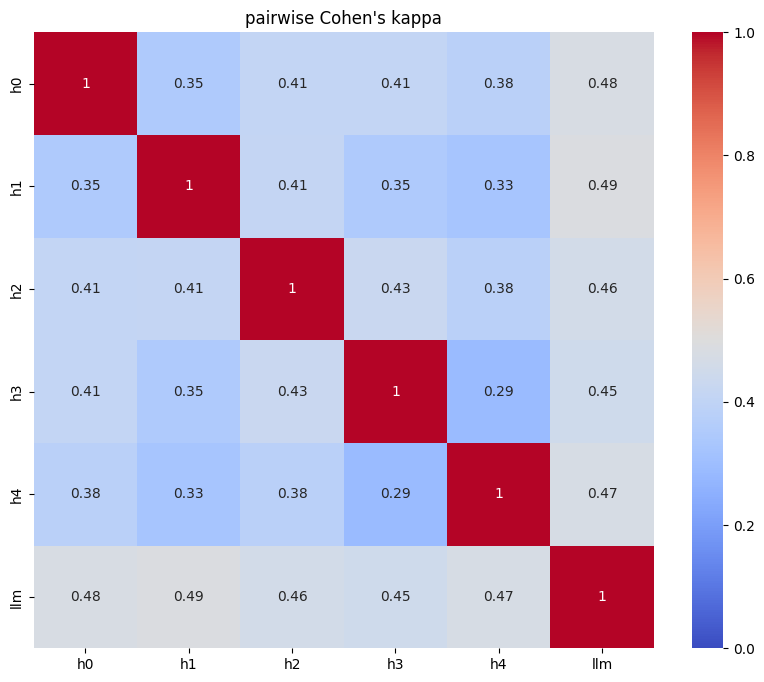

In [37]:
data = {
    'h0': [ pairwise_cm(df, 'h0', label).Kappa for label in labelers ],
    'h1': [ pairwise_cm(df, 'h1', label).Kappa for label in labelers ],
    'h2': [ pairwise_cm(df, 'h2', label).Kappa for label in labelers ],
    'h3': [ pairwise_cm(df, 'h3', label).Kappa for label in labelers ],
    'h4': [ pairwise_cm(df, 'h4', label).Kappa for label in labelers ],
    'llm': [ pairwise_cm(df, 'llm', label).Kappa for label in labelers ],
}

kappa_df = pd.DataFrame(data, index=['h0', 'h1', 'h2', 'h3', 'h4', 'llm'])

plt.figure(figsize=(10, 8))
sns.heatmap(kappa_df, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title('pairwise Cohen\'s kappa')
plt.show()

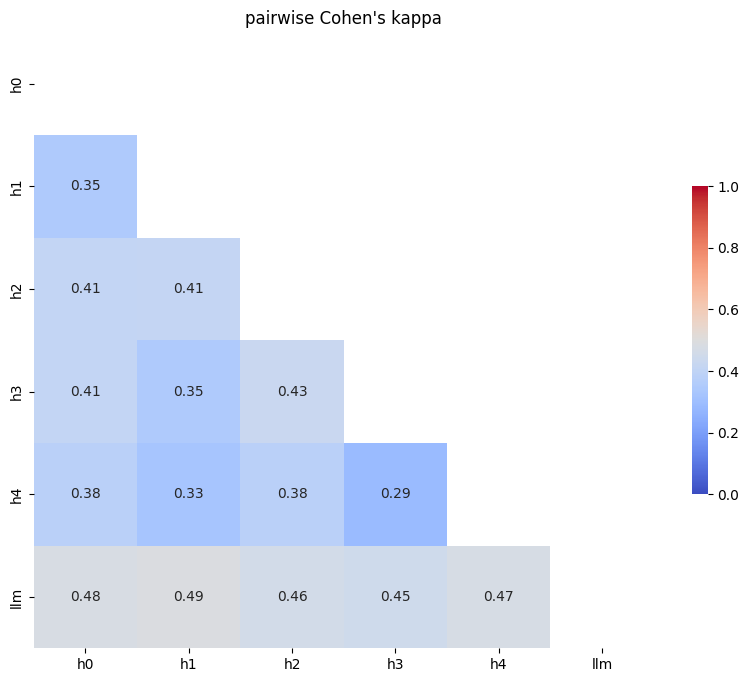

In [38]:
mask = np.triu(np.ones_like(kappa_df, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(kappa_df, annot=True, mask=mask, cmap="coolwarm", vmin=0, vmax=1, cbar_kws={'shrink': .5})
plt.title('pairwise Cohen\'s kappa')
plt.show()

In [70]:
pairwise_cm(df, 'h_consensus', 'llm')

pycm.ConfusionMatrix(classes: ['Hallucination', 'Not Hallucination'])

In [71]:
_.Kappa

0.6225753718779737

In [154]:
df_h_low_confidence = df[ (df["h_hallucination"] == 2) | (df["h_hallucination"] == 3) ]

In [155]:
df_h_high_confidence = df[ (df["h_hallucination"] == 4) | (df["h_hallucination"] == 1) ]

In [156]:
df_h_very_high_confidence = df[ (df["h_hallucination"] == 5) | (df["h_hallucination"] == 0) ]

In [157]:
len(df_h_high_confidence)

171

In [158]:
len(df_h_very_high_confidence)

183

In [159]:
len(df_h_low_confidence)

145

In [164]:
pairwise_cm(df_h_high_confidence, 'h_consensus', 'llm').Kappa

0.700944386149003

In [149]:
pairwise_cm(df_h_low_confidence, 'h_consensus', 'llm').Kappa

0.23779030870687193

In [163]:
pairwise_cm(df_h_high_confidence, 'h_consensus', 'llm').ACC

{'Hallucination': 0.8538011695906432, 'Not Hallucination': 0.8538011695906432}

In [148]:
pairwise_cm(df_h_low_confidence, 'h_consensus', 'llm').ACC

{'Hallucination': 0.6206896551724138, 'Not Hallucination': 0.6206896551724138}

In [82]:
pairwise_cm(df_h_very_high_confidence, 'h_consensus', 'llm').Kappa

0.8562103354487761

In [138]:
pairwise_cm(df_h_very_high_confidence, 'h_consensus', 'llm').ACC

{'Hallucination': 0.9289617486338798, 'Not Hallucination': 0.9289617486338798}

In [140]:
df_h_high_confidence

,h0,h1,h2,h3,h4,h_hallucination,h_not_hallucination,h_consensus,h_prob,llm,llm_prob,P_i
0,Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,1,4,Not Hallucination,0.2,Not Hallucination,0.00,0.6
1,Hallucination,Hallucination,Hallucination,Hallucination,Not Hallucination,4,1,Hallucination,0.8,Not Hallucination,0.00,0.6
2,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,0,5,Not Hallucination,0.0,Hallucination,0.65,1.0
3,Not Hallucination,Not Hallucination,Hallucination,Not Hallucination,Not Hallucination,1,4,Not Hallucination,0.2,Hallucination,1.00,0.6
4,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,0,5,Not Hallucination,0.0,Not Hallucination,0.10,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
494,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,0,5,Not Hallucination,0.0,Not Hallucination,0.00,1.0
495,Not Hallucination,Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,1,4,Not Hallucination,0.2,Not Hallucination,0.00,0.6
496,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,0,5,Not Hallucination,0.0,Not Hallucination,0.00,1.0
497,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,Not Hallucination,0,5,Not Hallucination,0.0,Not Hallucination,0.00,1.0


In [162]:

rho, pval = spearmanr(df_h_high_confidence['h_prob'], df_h_high_confidence['llm_prob'])
print(rho, pval)

0.7341239712201545 3.2144098737201325e-30


In [143]:

rho, pval = spearmanr(df_h_very_high_confidence['h_prob'], df_h_very_high_confidence['llm_prob'])
print(rho, pval)

0.8851735361864671 4.76337969427657e-62


In [145]:

rho, pval = spearmanr(df['h_prob'], df['llm_prob'])
print(rho, pval)

0.6966336513428443 1.0743796238398965e-73
